In [1]:
!ls

compute_preprocessing.toml           run-gen-training.sh
data_generation_coprec_training.toml run-preproc.sh
data_generation_coprec_val.toml      single-fits-no-time.ipynb
data_logs                            training_data
pre_processing                       validation_data


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [3]:
import tensorflow as tf

In [4]:
import sklearn.preprocessing

In [5]:
import wispy.callbacks

In [8]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [6]:
!ls training_data

alpha.npy  amp_22.npy coords.npy phi_21.npy times.npy
amp_21.npy beta.npy   gamma.npy  phi_22.npy


In [7]:
times = np.load("training_data/times.npy")
coords = np.load("training_data/coords.npy").T
phi_22 = np.load("training_data/phi_22.npy")
amp_22 = np.load("training_data/amp_22.npy")
beta = np.load("training_data/beta.npy")
val_phi_22 = np.load("validation_data/phi_22.npy")
val_amp_22 = np.load("validation_data/amp_22.npy")
val_beta = np.load("validation_data//beta.npy")
val_coords = np.load("validation_data/coords.npy").T

In [127]:
def get_derivative(t, A):
    return np.array([IUS(t, a).derivative()(t) for a in A])

In [128]:
d_beta = get_derivative(times, beta)

In [129]:
val_d_beta = get_derivative(times, val_beta)

In [130]:
d_beta.shape

(100, 1219)

In [131]:
coords.shape

(100, 7)

In [132]:
phi_22.shape

(100, 1219)

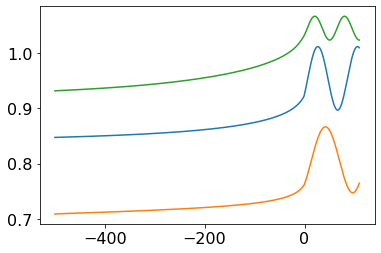

In [133]:
plt.figure()
plt.plot(times, beta[0])
plt.plot(times, beta[20])
plt.plot(times, beta[84])

In [134]:

X_train = coords.copy()
# y_train = phi_22.copy()
y_train = beta.copy()
# y_train = d_beta.copy()
# y_train = amp_22.copy()
# X_val = val_coords.copy()
# y_val = val_phi_22.copy()
y_val = val_beta.copy()
# y_val = val_d_beta.copy()
# y_val = val_amp_22.copy()






# y_train_scaler = sklearn.preprocessing.MinMaxScaler()
# y_train_scaler = sklearn.preprocessing.StandardScaler()
# y_train_scaler.fit(y_train)
# y_train = y_train_scaler.transform(y_train)
# y_val = y_train_scaler.transform(y_val)


# # y_scale = np.max(np.abs(phi_22))
y_scale = np.max(np.abs(beta))
# y_scale = np.max(np.abs(d_beta))
# # y_scale = np.max(np.abs(amp_22))
print(y_scale)
# X_train = coords.copy()
# # y_train = phi_22.copy()/y_scale
y_train = beta.copy()/y_scale
# y_train = d_beta.copy()/y_scale
# # y_train = amp_22.copy()/y_scale
X_val = val_coords.copy()
# # y_val = val_phi_22.copy()/y_scale
y_val = val_beta.copy()/y_scale
# y_val = val_d_beta.copy()/y_scale
# # y_val = val_amp_22.copy()/y_scale



# y_train = y_train - y_train[:,0][:,np.newaxis]
# y_val = y_val - y_val[:,0][:,np.newaxis]

1.0656906195032667


In [135]:
y_train[0]

array([0.79495737, 0.79496921, 0.79498105, ..., 0.94759689, 0.94715201,
       0.94662834])

In [136]:
coords[:,1].argmax()

84

In [137]:
coords[84]

array([5.        , 0.98683103, 1.5707963 , 0.        , 0.        ,
       0.        , 0.        ])

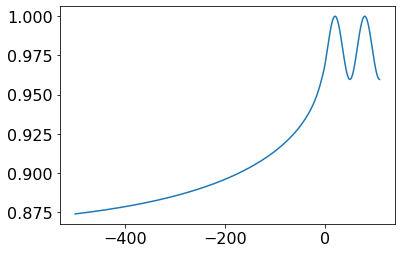

In [138]:
plt.figure()
plt.plot(times, y_train[84])

In [139]:
import pugna.activations
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [140]:
import pugna.models

In [141]:
import wispy.resnet

In [142]:
def build_model(input_shape, output_shape, units, activation, n_hidden_layers):
    
    input_layer = tf.keras.Input(shape=(input_shape,))
    x = input_layer
    for i in range(n_hidden_layers):
        x = tf.keras.layers.Dense(units, activation=activation)(x)
    output_layer = tf.keras.layers.Dense(output_shape)(x)
    
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [143]:
model_1_params = dict(
    input_shape=X_train.shape[1],
    output_shape=y_train.shape[1],
    units=128,
    activation='relu',
    n_hidden_layers=3
)

In [144]:
model_2_params = dict(
    input_shape=X_train.shape[1],
    output_shape=y_train.shape[1],
    units=256,
    activation='s2relu',
    n_hidden_layers=3)

In [145]:
model_2a_params = dict(
    input_shape=X_train.shape[1],
    output_shape=y_train.shape[1],
    units=128,
    activation='s2relu',
    n_hidden_layers=6
)

In [146]:
model_3_params = dict(
    input_shape=X_train.shape[1],
    output_shape=y_train.shape[1],
    units=128,
    activation='elu',
    n_hidden_layers=3)

In [147]:
pugna_model_params = dict(
    input_dim=X_train.shape[1],
    output_dim=y_train.shape[1],
    nlayers=3,
    units=[128,128,128],
    nscales=[100,1,1,1],
    activations=['s2relu','s2relu','s2relu'],
    dropouts=[0.,0.,0.],
    batch_norms=[False,False,False],
    scale_names=["base2","linear","linear"],
    bias_initializer="random_normal"
)

In [148]:
resnet_model_params = dict(
    input_shape=X_train.shape[1],
    output_shape=y_train.shape[1],
    width=128,
    num_blocks=2,
    group_norm=True,
    groups=1,
    batch_norm=False,
    momentum=0.9
)

In [149]:
model_1 = build_model(**model_1_params)

In [150]:
model_2 = build_model(**model_2_params)

In [151]:
model_2a = build_model(**model_2a_params)

In [152]:
model_3 = build_model(**model_3_params)

In [153]:
pugna_model = pugna.models.mscalednn.build_model(**pugna_model_params)

In [154]:
resnet_model = wispy.resnet.ResNet(**resnet_model_params)

In [155]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [156]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [157]:
model_2a.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [158]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [159]:
pugna_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [160]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [57]:
%%time
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(factor=0.95, patience=100)]
history_1 = model_1.fit(X_train, y_train, epochs=700, batch_size=800, validation_data=(X_val, y_val), verbose=False, callbacks=callbacks)

CPU times: user 27.6 s, sys: 2.47 s, total: 30.1 s
Wall time: 25.2 s


In [161]:
%%time
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(factor=0.95, patience=100, min_lr=1e-5), wispy.callbacks.ThresholdCallback(1e-6)]
history_2 = model_2.fit(X_train, y_train, epochs=1500, batch_size=800, validation_data=(X_val, y_val), verbose=False, callbacks=callbacks)

CPU times: user 1min 11s, sys: 16.4 s, total: 1min 27s
Wall time: 59.1 s


In [59]:
%%time
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(factor=0.95, patience=100)]
# callbacks=None
history_2a = model_2a.fit(X_train, y_train, epochs=700, batch_size=800, validation_data=(X_val, y_val), verbose=False, callbacks=callbacks)

CPU times: user 31.8 s, sys: 6.92 s, total: 38.7 s
Wall time: 27.8 s


In [60]:
%%time
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(factor=0.95, patience=100)]
history_3 = model_3.fit(X_train, y_train, epochs=700, batch_size=800, validation_data=(X_val, y_val), verbose=False, callbacks=callbacks)

CPU times: user 27.8 s, sys: 2.62 s, total: 30.4 s
Wall time: 25.3 s


In [61]:
%%time
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(factor=0.95, patience=100)]
pugna_history = pugna_model.fit(X_train, y_train, epochs=700, batch_size=800, validation_data=(X_val, y_val), verbose=False, callbacks=callbacks)

CPU times: user 29.8 s, sys: 5.99 s, total: 35.7 s
Wall time: 27 s


In [62]:
%%time
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(factor=0.95, patience=100)]
resnet_history = resnet_model.fit(X_train, y_train, epochs=700, batch_size=800, validation_data=(X_val, y_val), verbose=False, callbacks=callbacks)

CPU times: user 47.3 s, sys: 9.62 s, total: 56.9 s
Wall time: 37.4 s


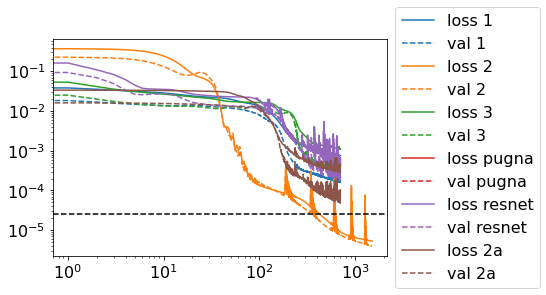

In [162]:
plt.figure()
plt.plot(history_1.history['loss'], label='loss 1', c='C0')
plt.plot(history_1.history['val_loss'], label='val 1', c='C0', ls='--')
plt.plot(history_2.history['loss'], label='loss 2', c='C1')
plt.plot(history_2.history['val_loss'], label='val 2', c='C1', ls='--')
plt.plot(history_3.history['loss'], label='loss 3', c='C2')
plt.plot(history_3.history['val_loss'], label='val 3', c='C2', ls='--')
plt.plot(pugna_history.history['loss'], label='loss pugna', c='C3')
plt.plot(pugna_history.history['val_loss'], label='val pugna', c='C3', ls='--')
plt.plot(resnet_history.history['loss'], label='loss resnet', c='C4')
plt.plot(resnet_history.history['val_loss'], label='val resnet', c='C4', ls='--')

plt.plot(history_2a.history['loss'], label='loss 2a', c='C5')
plt.plot(history_2a.history['val_loss'], label='val 2a', c='C5', ls='--')

plt.axhline(2.531e-05, c='k', ls='--')

plt.yscale('log')
plt.xscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

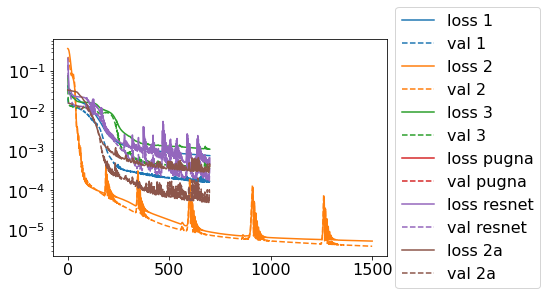

In [163]:
plt.figure()
plt.plot(history_1.history['loss'], label='loss 1', c='C0')
plt.plot(history_1.history['val_loss'], label='val 1', c='C0', ls='--')
plt.plot(history_2.history['loss'], label='loss 2', c='C1')
plt.plot(history_2.history['val_loss'], label='val 2', c='C1', ls='--')
plt.plot(history_3.history['loss'], label='loss 3', c='C2')
plt.plot(history_3.history['val_loss'], label='val 3', c='C2', ls='--')
plt.plot(pugna_history.history['loss'], label='loss pugna', c='C3')
plt.plot(pugna_history.history['val_loss'], label='val pugna', c='C3', ls='--')
plt.plot(resnet_history.history['loss'], label='loss resnet', c='C4')
plt.plot(resnet_history.history['val_loss'], label='val resnet', c='C4', ls='--')

plt.plot(history_2a.history['loss'], label='loss 2a', c='C5')
plt.plot(history_2a.history['val_loss'], label='val 2a', c='C5', ls='--')

plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

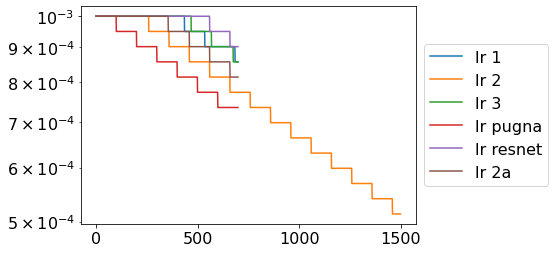

In [164]:
plt.figure()
plt.plot(history_1.history['lr'], label='lr 1', c='C0')
plt.plot(history_2.history['lr'], label='lr 2', c='C1')
plt.plot(history_3.history['lr'], label='lr 3', c='C2')
plt.plot(pugna_history.history['lr'], label='lr pugna', c='C3')
plt.plot(resnet_history.history['lr'], label='lr resnet', c='C4')
plt.plot(history_2a.history['lr'], label='lr 2a', c='C5')

plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [203]:
index = 3

In [204]:
yhat1 = model_1.predict(X_train[index].reshape(1,-1))[0]
yhat2 = model_2.predict(X_train[index].reshape(1,-1))[0]
yhat3 = model_3.predict(X_train[index].reshape(1,-1))[0]
yhat_pugna = pugna_model.predict(X_train[index].reshape(1,-1))[0]
yhat_resnet = resnet_model.predict(X_train[index].reshape(1,-1))[0]
yhat2a = model_2a.predict(X_train[index].reshape(1,-1))[0]

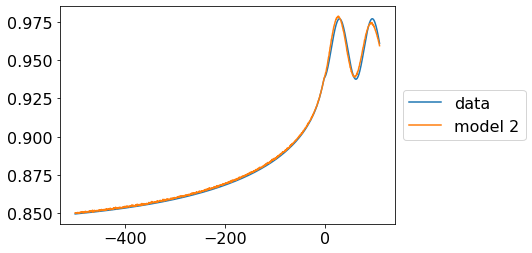

In [205]:
plt.figure()
plt.plot(times, y_train[index], label='data')
# plt.plot(times, yhat1, label='model 1')
plt.plot(times, yhat2, label='model 2')
# plt.plot(times, yhat3, label='model 3')
# plt.plot(times, yhat_pugna, label='model pugna')
# plt.plot(times, yhat_resnet, label='model resnet')
# plt.plot(times, yhat2a, label='model 2a')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-100, 100)

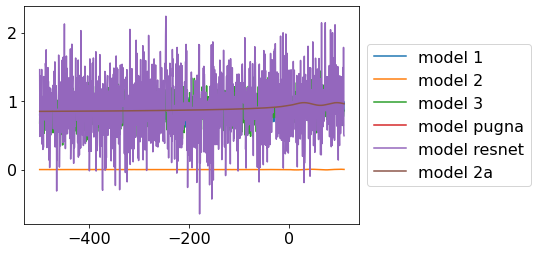

In [206]:
plt.figure()
plt.plot(times, y_train[index]-yhat1, label='model 1')
plt.plot(times, y_train[index]-yhat2, label='model 2')
plt.plot(times, y_train[index]-yhat3, label='model 3')
plt.plot(times, y_train[index]-yhat_pugna, label='model pugna')
plt.plot(times, y_train[index]-yhat_resnet, label='model resnet')
plt.plot(times, y_train[index]-yhat2a, label='model 2a')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

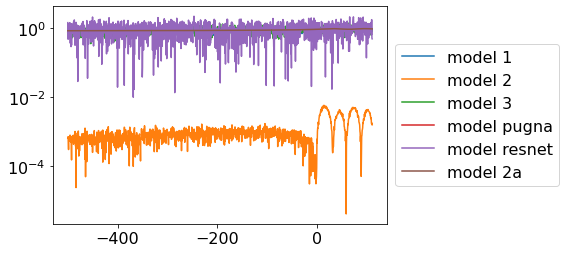

In [207]:
plt.figure()
plt.plot(times, np.abs(y_train[index]-yhat1), label='model 1')
plt.plot(times, np.abs(y_train[index]-yhat2), label='model 2')
plt.plot(times, np.abs(y_train[index]-yhat3), label='model 3')
plt.plot(times, np.abs(y_train[index]-yhat_pugna), label='model pugna')
plt.plot(times, np.abs(y_train[index]-yhat_resnet), label='model resnet')
plt.plot(times, np.abs(y_train[index]-yhat2a), label='model 2a')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

In [208]:
# compare true derivative with predicted derivative

In [209]:
# just doing this by hand instead of autograd because i'm lazy

In [210]:
times.shape

(1219,)

In [211]:
yhat2.shape

(1219,)

In [212]:
d_yhat2 = get_derivative(times, yhat2[np.newaxis,:])

In [213]:
d_yhat2.shape

(1, 1219)

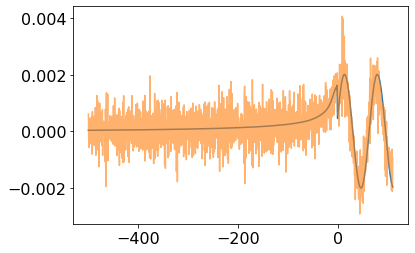

In [214]:
plt.figure()
plt.plot(times, d_beta[index])
plt.plot(times, d_yhat2[0], alpha=0.6)

# try fitting just one beta

In [526]:
y_train.shape

(100, 1219)

In [168]:
single_model_2_params = dict(
    input_shape=X_train.shape[1],
    output_shape=y_train.shape[1],
    units=256,
    activation='s2relu',
    n_hidden_layers=3)
single_model_2 = build_model(**single_model_2_params)
single_model_2.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [169]:
X_train[0].shape

(7,)

In [537]:
X_train[0].reshape(1,-1).shape

(1, 7)

In [538]:
%%time
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(factor=0.95, patience=100)]
single_history_2 = single_model_2.fit(X_train[0].reshape(1, -1), y_train[0].reshape(1,-1), epochs=700, batch_size=800, validation_data=(X_val, y_val), verbose=False, callbacks=callbacks)

CPU times: user 23.9 s, sys: 1.75 s, total: 25.7 s
Wall time: 22.7 s


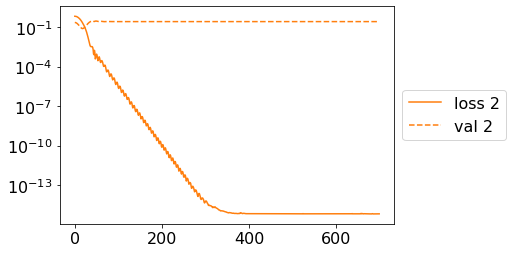

In [539]:
plt.figure()
plt.plot(single_history_2.history['loss'], label='loss 2', c='C1')
plt.plot(single_history_2.history['val_loss'], label='val 2', c='C1', ls='--')

plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

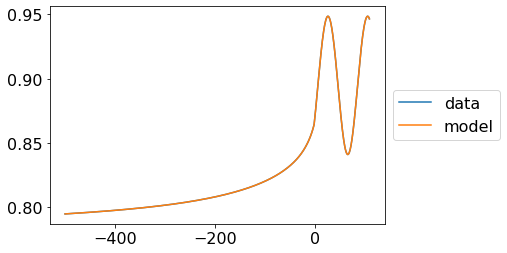

In [540]:
plt.figure()
plt.plot(times, y_train[0], label='data')
plt.plot(times, single_model_2.predict(X_train)[0], label='model')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-100, 100)

# try fitting just 5 beta

In [541]:
y_train.shape

(100, 1219)

In [685]:
five_model_2_params = dict(
    input_shape=X_train.shape[1],
    output_shape=y_train.shape[1],
    units=256,
    activation='s2relu',
    n_hidden_layers=3)
five_model_2 = build_model(**five_model_2_params)
five_model_2.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [686]:
X_train[0].shape

(7,)

In [687]:
X_train[0].reshape(1,-1).shape

(1, 7)

In [698]:
five_X_train = X_train[:5]
five_y_train = y_train[:5]


# five_y_train = y_train[:5] - y_train[:5,0][:,np.newaxis]
# five_y_train /= five_y_train.max()


scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(five_y_train)

five_y_train = scaler.transform(five_y_train)

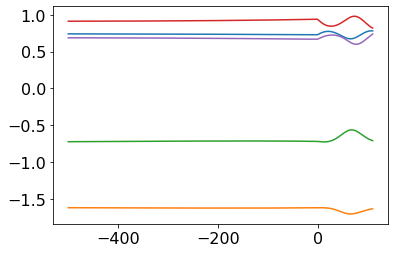

In [699]:
plt.figure()
for yy in five_y_train:
    plt.plot(times, yy)

In [700]:
five_X_train.shape

(5, 7)

In [701]:
%%time
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(factor=0.95, patience=100)]
five_history_2 = five_model_2.fit(five_X_train, five_y_train, epochs=700, batch_size=800, validation_data=(X_val, y_val), verbose=False, callbacks=callbacks)

CPU times: user 25.3 s, sys: 1.93 s, total: 27.2 s
Wall time: 23.5 s


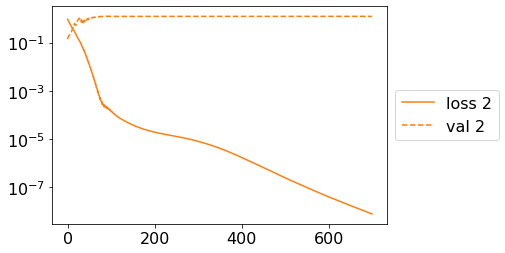

In [702]:
plt.figure()
plt.plot(five_history_2.history['loss'], label='loss 2', c='C1')
plt.plot(five_history_2.history['val_loss'], label='val 2', c='C1', ls='--')

plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

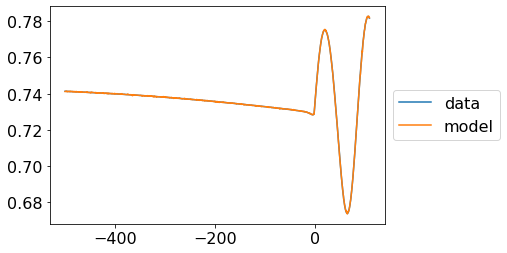

In [703]:
plt.figure()
plt.plot(times, five_y_train[0], label='data')
plt.plot(times, five_model_2.predict(five_X_train)[0], label='model')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-100, 100)

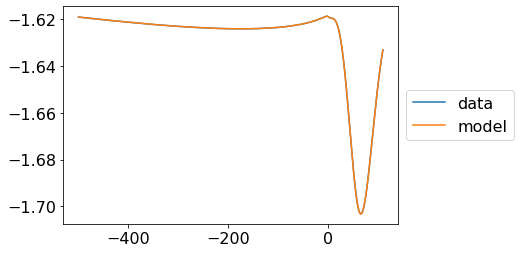

In [704]:
plt.figure()
plt.plot(times, five_y_train[1], label='data')
plt.plot(times, five_model_2.predict(five_X_train)[1], label='model')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-100, 100)